# SINDy Representation

An experiment using SINDy to represent a dataset.

### Install Requirements

In [29]:
# Upgrade pip
!python3 -m pip install -q -U pip

# Install from requirements.txt
%pip install -q -r requirements.txt

# # Or:
# # ---------------------------
# # Manual Install Requirements (assuming `pip install notebook` or `pip install jupyterlab` has already run)
# 
# # For datasets
# %pip install -q numpy pandas
#  
# # For LASSO and ODE and PDE support
# %pip install -q scikit-learn scipy
#  
# # For plotting
# %pip install -q matplotlib seaborn
#  
# # For SINDy implementation
# %pip install -q pysindy

%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as ode

# # Uncomment when running as non jupyter notebook
# import matplotlib
# matplotlib.use('TkAgg')

import pysindy as ps
import pysindy.utils as psutils

import joblib
# # Uncomment when running as non jupyter notebook
# import pprint
# display = pprint.pprint

# Set seed for reproducible results
np.random.seed(100)

# Add print formatting for np
np.set_printoptions(linewidth=np.inf, precision=3, suppress=True)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

### Generate Input (Starting State) and Training Data (Full State) for fitting

#### Generating Starting State

We create a random starting state (in this case x = -16, y = 4, and z = 8). This represents the first row of the matrix $X$ in pysindy.

$$
x(t = 0) = \begin{bmatrix}x(t = 0) & y(t = 0) & z(t = 0)\end{bmatrix}
$$

#### Generating Full State

We use the Lorenz System (an Original Differential Equation) to generate an example system values to learn by SINDy.

We define that the states are equidistant in time $\Delta t = 0.001$ and have times $t \in [0, 10]$.

We can define the full states at all times $t$ (this is represented by an entire row in the matrix) to look as the following:

$$
X = \begin{bmatrix}
    x = -16 & y = 4 & z = 8 \\
    \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [17]:
def generate_lorenz_states(times, starting_state):
  time_range = (times[0], times[-1])

  # Generate the lorenz system values (states)
  result = ode.solve_ivp(
      psutils.lorenz,
      time_range,
      starting_state,
      t_eval=times,
      method='LSODA',
      rtol=1e-12,
      atol=1e-12,
  )
  
  states = result.y.T
  return states

In [18]:
FEATURE_NAMES = ['x', 'y', 'z']
dt = 1e-3

time_start_train = 0
time_end_train = 10
#                      x  y  z
x0_train = np.array([-16, 4, 8])

t_train = np.arange(time_start_train, time_end_train, dt)
X_train = generate_lorenz_states(t_train, x0_train)

time_start_test = 0
time_end_test = 15
#                   x  y   z
x0_test = np.array([4, 2, 16])

t_test = np.arange(time_start_test, time_end_test, dt)
X_test = generate_lorenz_states(t_test, x0_test)

In [ ]:
print("Train Initial State (t _ 0 = 0)")
print("x0 = ")
display(x0_train)
print()

print("(Transpose of) Train Times t _ i for 0 <= t < m")
display(t_train.reshape((-1, 1)))
print()

Train Initial State (t _ 0 = 0)
x0 = 


array([-16,   4,   8])


(Transpose of) Train Times t _ i for 0 <= t < m


array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [9.997],
       [9.998],
       [9.999]], shape=(10000, 1))

In [ ]:
print("States:  x         y        z      ")
display(X_train)
print()

States:  x         y        z      


array([[-16.   ,   4.   ,   8.   ],
       [-15.803,   3.677,   7.918],
       [-15.61 ,   3.358,   7.841],
       ...,
       [ -3.857,  -3.513,  22.264],
       [ -3.854,  -3.532,  22.218],
       [ -3.851,  -3.55 ,  22.173]], shape=(10000, 3))

### Fit the SINDy model on the Full State

We use a Polynomial Feature Library for our model (default). We provide it with the full (or at least the collected) $X$ that represents all states that are $k \Delta t$ time away from each other ($\exists k$).

In [21]:
model = ps.SINDy()
model.fit(X_train, t=dt, feature_names=FEATURE_NAMES)

,optimizer,STLSQ()
,feature_library,PolynomialLibrary()
,differentiation_method,FiniteDifference()
,discrete_time,False
,degree,2
,include_interaction,True
,interaction_only,False
,include_bias,True
,order,'C'
,threshold,0.1
,alpha,0.05


### Analyze Results

We look at the coefficient matrix $\Xi$ to understand the coefficients of the learned differential equations.

The function that we multiply the coefficients by can be found in the Feature Library. Once found, the differential equation is:

$$
\hat{x}_i = \sum _ {j = 0} ^ {p} {\xi _ i \cdot f_j(x_i)}
$$

In [22]:
def print_feature_library(model, feature_names):
    feature_library = model.feature_library
    all_candidates = feature_library.get_feature_names(input_features=feature_names)

    print('Feature Library (aligned with coefficient `col`):')

    # Column
    print('Col:', end='      ')
    for col in range(len(all_candidates)):
        print(f'{col:<3}', end='      ')
    print()

    # Terms associated with numbering
    print('Term:', end='     ')
    for term in all_candidates:
        print(f'{term:<3}', end='      ')
    print()

In [23]:
print('Governing Differential Equations:')
model.print()
print()

xi = model.coefficients()

print('Sparse Coefficient Matrix:')
display(xi)
print()

print_feature_library(model, FEATURE_NAMES)
print()

score = model.score(X_test, t=dt)
print(f'Prediction Score on X_test: {score}')

Governing Differential Equations:
(x)' = -10.000 x + 10.000 y
(y)' = 27.999 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

Sparse Coefficient Matrix:


array([[  0.   , -10.   ,  10.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,  27.999,  -1.   ,   0.   ,   0.   ,   0.   ,  -1.   ,   0.   ,   0.   ,   0.   ],
       [  0.   ,   0.   ,   0.   ,  -2.667,   0.   ,   1.   ,   0.   ,   0.   ,   0.   ,   0.   ]])


Feature Library (aligned with coefficient `col`):
Col:      0        1        2        3        4        5        6        7        8        9        
Term:     1        x        y        z        x^2      x y      x z      y^2      y z      z^2      

Prediction Score on X_test: 0.9999999989628875


In [24]:
def plot_3d_model_states(actual, predicted, feature_names):
    if len(feature_names) != 3:
        raise Exception('len(feature_names) != 3')
    
    fig = plt.figure(figsize=(14, 8))

    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.set_title('Actual States')
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.plot(actual[:, 0], actual[:, 1], actual[:, 2], color='black', linestyle='-')

    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_title('Predicted States')
    ax.set_xlabel(feature_names[0])
    ax.set_ylabel(feature_names[1])
    ax.set_zlabel(feature_names[2])
    ax.plot(predicted[:, 0], predicted[:, 1], predicted[:, 2], color='red', linestyle='--')
    
    fig.show()

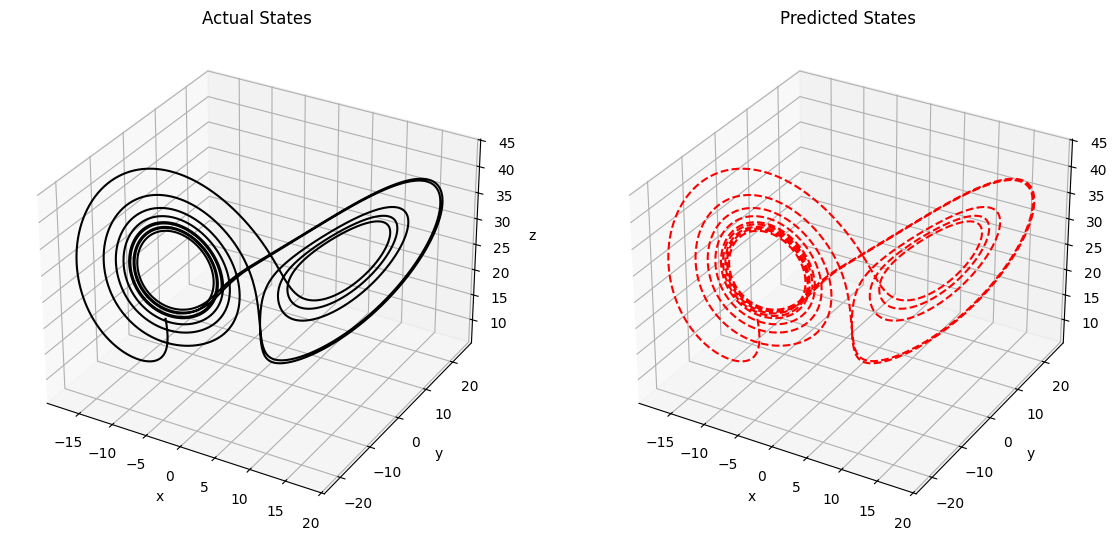

In [25]:
X_train_pred = model.simulate(x0_train, t_train)
plot_3d_model_states(X_train, X_train_pred, FEATURE_NAMES)

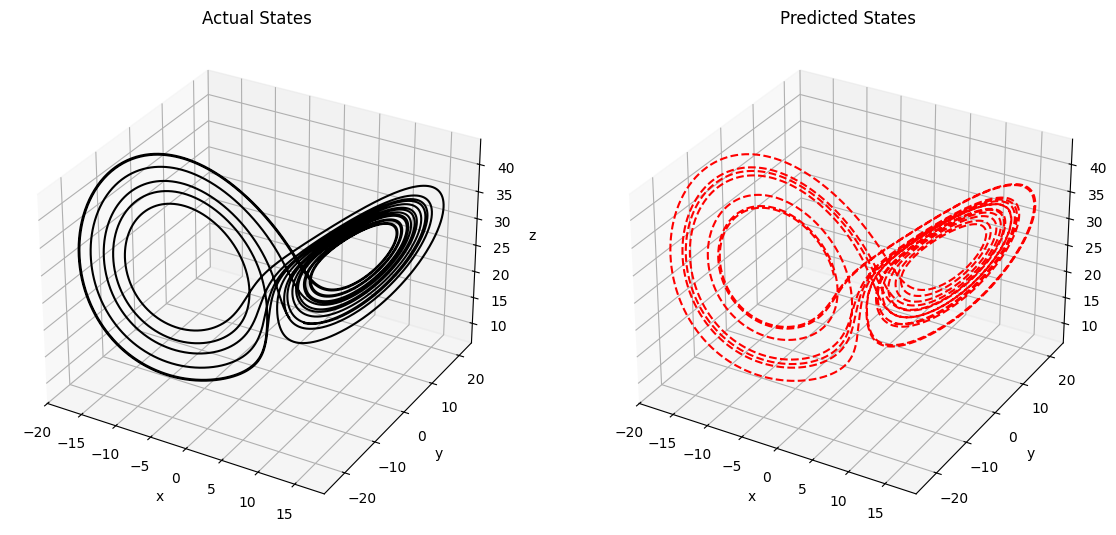

In [26]:
X_test_pred = model.simulate(x0_test, t_test)
plot_3d_model_states(X_test, X_test_pred, FEATURE_NAMES)

### Save the Model in a File

This file represents the trained SINDy model. Since PySINDy uses scikit-learn, we can use joblib as a (simple) way to dump the model into a file.

The file stores the following attributes:

```python
"""
...

_Base_SINDy: ``BaseEstimator``

    Contains:
    - feature_library: BaseFeatureLibrary
    - optimizer: _BaseOptimizer
    - model: Pipeline
    - feature_names: Optional[list[str]]
    - discrete_time: bool = False
    - n_control_features_: int = 0

model : ``sklearn.multioutput.MultiOutputRegressor``
    The fitted SINDy model.

n_input_features_ : int
    The total number of input features.

n_output_features_ : int
    The total number of output features. This number is a function of
    ``self.n_input_features`` and the feature library being used.

n_control_features_ : int
    The total number of control input features.

...
"""
```

**Note**: The data is about 1.1 MiB of data for this small example.

In [27]:
MODEL_FILENAME = "pysindy_lorenz.joblib"

joblib.dump(model, MODEL_FILENAME)

print(f"Created file '{MODEL_FILENAME}'")
print()

print('File Size:')
!du -sh "pysindy_lorenz.joblib"

Created file 'pysindy_lorenz.joblib'

File Size:
1.1M	pysindy_lorenz.joblib


### Read in the Model from the File

We can then load the model from this file just like a scikit-learn model, and use it again.

Governing Differential Equations:
(x)' = -10.000 x + 10.000 y
(y)' = 27.999 x + -1.000 y + -1.000 x z
(z)' = -2.667 z + 1.000 x y

Feature Library (aligned with coefficient `col`):
Col:      0        1        2        3        4        5        6        7        8        9        
Term:     1        x        y        z        x^2      x y      x z      y^2      y z      z^2      



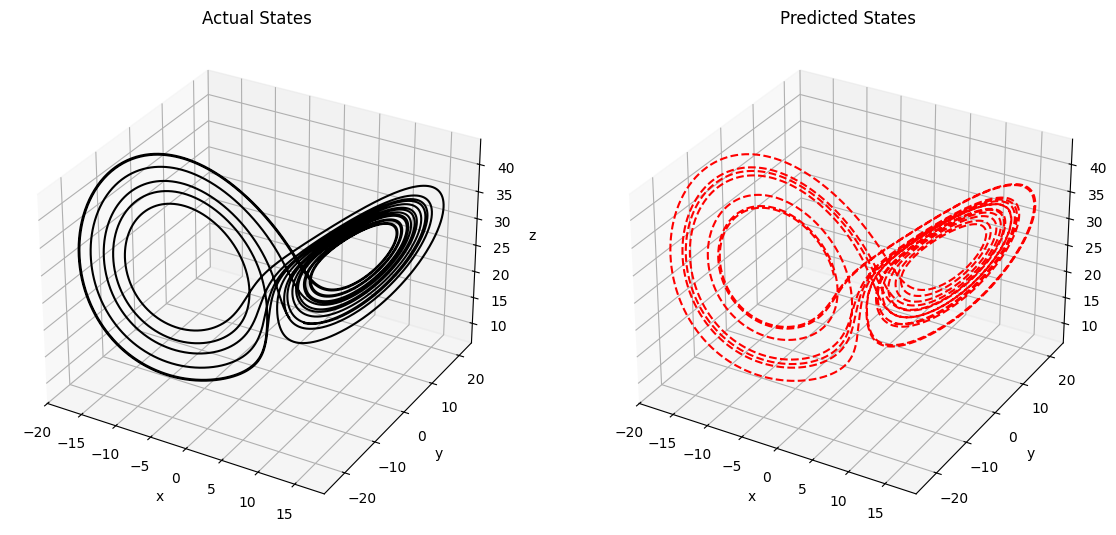

In [28]:
loaded_model = joblib.load(MODEL_FILENAME)

print('Governing Differential Equations:')
loaded_model.print()
print()

print_feature_library(loaded_model, FEATURE_NAMES)
print()

X_test_pred = loaded_model.simulate(x0_test, t_test)
plot_3d_model_states(X_test, X_test_pred, FEATURE_NAMES)

## Summary / Reference Guide

### Input:

Starting State:

$$
x(t = 0) = \begin{bmatrix}x_0(t = 0) & x_1(t = 0) & x_2(t = 0) & \dots & x_n(t = 0) \end{bmatrix}
$$

Sequence of equidistant times:

$$
T = \{t _ i \colon \lvert t_{i + 1} - t_{i} \rvert = \Delta t, \ \forall i \geq 0 \} \quad \exists \Delta t > 0
$$

(Theoretical Input):

Assume that $t_0 = 0$ and $\Delta t = 1$.

$$
X = \begin{bmatrix}
    x_0 & x_1 & x_2 & (x(t = 0)) \\
    x_0 + \hat{x}_0 & x_1 + \hat{x}_1 & x_2 + \hat{x}_2 & (x(t = 1)) \\
    \vdots & \vdots & \vdots &
\end{bmatrix}
$$


### Output:

$$
\Xi = \begin{bmatrix}
    \xi _ 0(x_0) & \xi _ 1(x_0) & \dots \\
    \xi _ 0(x_1) & \xi _ 1(x_1) & \dots \\
    \xi _ 0(x_2) & \xi _ 1(x_2) & \dots \\
\end{bmatrix}
$$

Can understand by using the feature library (can choose from [PySINDy's feature_library](https://github.com/dynamicslab/pysindy/tree/master/pysindy/feature_library), the default is their Polynomial Library):

$$
\Theta(X) = \begin{bmatrix}
    f_1 & f_2 & \dots & f_p \\
\end{bmatrix}
$$

where the change of state (derivative) from the state $x_0(0)$ to any new state $x_0(1)$ is:

$$
\hat{x}_i = \sum _ {j = 0} ^ {p} {\xi _ i \cdot f_j(x_i)}
$$

Which means we can construct all states $x(t _ k) = \begin{bmatrix}x_0(t _ k) & x_1(t _ k) & \dots & x_n(t _ k) \end{bmatrix}$ at time $t _ k = t_0 + k \Delta t$ for positive $k$ using the following equation:

$$
x_i(t _ k) = x_i(t _ 0) + k \cdot \hat{x}_i
$$

In [ ]:
# # Uncomment when in non jupyter notebook
# input('\nPress [Enter] to exit ')